# AdaptiveIS-CE-rare-event.ipynb (smoothed version)
Adaptive Importance Sampling with the Cross-Entropy (CE) method for the rare event $P(X>3)$ under $X\sim\mathcal{N}(0,1)$.

This version adds **parameter smoothing** and a **variance floor** to avoid
overly aggressive, unstable updates that collapse the proposal.

Initial (mu, sigma) = (1.0, 2.0)
Final (mu, sigma)   = (7.594434205021285, 0.4)
ESS per iteration: [2279.7981752191454, 334.761437828762, 1.5270212434177013, 1.7651897834394936, 7.742981510076233, 4.228025154032993, 2.796012309515173, 1.4583764014167093, 9.868967812568116, 2.975675070264538]
Saved figure to figs/CE_rare_event_panels.png


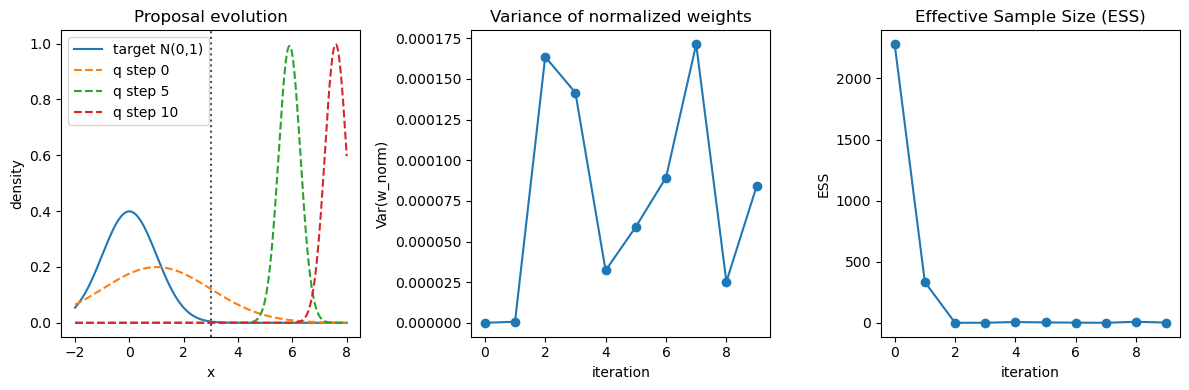

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

# Ensure figs directory exists (relative to notebook)
os.makedirs("figs", exist_ok=True)

# Target distribution N(0,1)
target = norm(loc=0.0, scale=1.0)

# Initial proposal parameters
mu0 = 1.0
sigma0 = 2.0

# CE / AIS parameters
rho = 0.2            # elite fraction (more elites -> smoother updates)
num_iter = 10        # number of CE iterations
N = 4000             # samples per iteration
alpha = 0.6          # smoothing factor in [0,1]; 1.0 => no smoothing
sigma_floor = 0.4    # minimum allowed sigma to avoid delta-like collapse

# Storage for diagnostics
mus = [mu0]
sigmas = [sigma0]
weight_vars = []
ess_list = []

rng = np.random.default_rng(123)

for t in range(num_iter):
    mu_t = mus[-1]
    sigma_t = sigmas[-1]
    proposal = norm(loc=mu_t, scale=sigma_t)

    # Sample from current proposal
    x = proposal.rvs(size=N, random_state=rng)

    # Importance weights for the rare event estimator
    w = target.pdf(x) / proposal.pdf(x)

    # Diagnostics: normalized weights, variance, ESS
    w_norm = w / np.sum(w)
    weight_vars.append(np.var(w_norm))
    ess = 1.0 / np.sum(w_norm**2)
    ess_list.append(ess)

    # CE-style elite selection:
    # We want proposals that are good for x>3, so we rank by x.
    threshold = np.quantile(x, 1.0 - rho)
    elite = x[x >= threshold]

    elite_mu = np.mean(elite)
    elite_sigma = np.std(elite, ddof=1)

    # Smoothed parameter update
    new_mu = alpha * elite_mu + (1.0 - alpha) * mu_t
    new_sigma = np.sqrt(
        alpha * (elite_sigma**2) + (1.0 - alpha) * (sigma_t**2)
    )

    # Apply variance floor to avoid degeneracy
    new_sigma = max(new_sigma, sigma_floor)

    mus.append(new_mu)
    sigmas.append(new_sigma)

# Print final parameters and diagnostics
print("Initial (mu, sigma) =", (mu0, sigma0))
print("Final (mu, sigma)   =", (mus[-1], sigmas[-1]))
print("ESS per iteration:", ess_list)

# Build figure with three panels
xs = np.linspace(-2, 8, 400)

plt.figure(figsize=(12, 4))

# Panel 1: evolution of proposal densities
plt.subplot(1, 3, 1)
plt.plot(xs, target.pdf(xs), label="target N(0,1)")
indices_to_plot = [0, num_iter//2, num_iter]
for idx in indices_to_plot:
    mu_p = mus[idx]
    sigma_p = sigmas[idx]
    proposal_p = norm(loc=mu_p, scale=sigma_p)
    plt.plot(xs, proposal_p.pdf(xs), linestyle="--", label=f"q step {idx}")
plt.axvline(3.0, linestyle=":", color="k", alpha=0.7)
plt.title("Proposal evolution")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()

# Panel 2: weight variance over iterations
plt.subplot(1, 3, 2)
plt.plot(range(num_iter), weight_vars, marker="o")
plt.title("Variance of normalized weights")
plt.xlabel("iteration")
plt.ylabel("Var(w_norm)")

# Panel 3: ESS over iterations
plt.subplot(1, 3, 3)
plt.plot(range(num_iter), ess_list, marker="o")
plt.title("Effective Sample Size (ESS)")
plt.xlabel("iteration")
plt.ylabel("ESS")

plt.tight_layout()
savepath = "figs/CE_rare_event_panels.png"
plt.savefig(savepath, dpi=150, bbox_inches="tight")
print(f"Saved figure to {savepath}")
plt.show()